In [234]:
# Basics
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Models
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Misc
import sys
from IPython.display import clear_output

%run utils/utils_metrics.py
%run utils/utils_line_supercover.py

%run utils/feature-extractor/feat_extraction.py

### 1. Load data

In [142]:
n_chunks = 1
chunks = [pkl.load(open('../data/bin_chunks/ttd_chunk_{0}.pkl'.format(i), 'rb')) for i in range(1, n_chunks + 1)]
dataset = pd.concat(chunks)
print("Data shape:", dataset.shape)

dataset.reset_index(inplace=True)
dataset.drop('index',axis=1,inplace=True)

dataset.head()

Data shape: (48605, 10)


,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387
1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648
2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070
3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045
4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123


### 2. Extracting features

In [143]:
# Instantiate a (concrete) component
featExtractor = FeatureExtractor(dataset=dataset)

# Decorate with features
featExtractor = CoordinatesFeature(featExtractor)
featExtractor = VectorDistanceFeature(featExtractor)
featExtractor = GridTripDistanceFeature(featExtractor)
featExtractor = AvgHourFeature(featExtractor)
featExtractor = WeekDayFeature(featExtractor)

# Extract them
features = featExtractor.getFeatures()
features.head()

Extracting Coordinates Features...
Extracting VectorDistance Features...
Extracting GridTripDistance Features...
Started prediction on grid of size 300x300
Normalizing data...
Prediction has started.
Finished.

Extracting AvgHour Features...
Extracting WeekDay Features...


,pu_lon,pu_lat,do_lon,do_lat,vec_dist,grid_trip_dist,avg_hour,avg_hour_sin,avg_hour_cos,week_day,week_day_sin,week_day_cos
0,-73.995750,40.764488,-73.926292,40.867458,7.983998,9.256702,20,-0.866025,5.000000e-01,1,0.781831,0.623490
1,-73.994110,40.751068,-73.993401,40.736019,1.039087,1.336709,10,0.500000,-8.660254e-01,3,0.433884,-0.900969
2,-73.973160,40.752728,-73.982178,40.756962,0.556130,0.720743,14,-0.500000,-8.660254e-01,6,-0.781831,0.623490
3,-73.991280,40.744808,-73.985909,40.731178,0.981839,1.277223,22,-0.500000,8.660254e-01,3,0.433884,-0.900969
4,-73.992897,40.741280,-73.975967,40.748734,1.026608,1.314838,18,-1.000000,-1.836970e-16,5,-0.974928,-0.222521


In [144]:
features.drop(['avg_hour','week_day'],axis=1,inplace=True)
features.head()

,pu_lon,pu_lat,do_lon,do_lat,vec_dist,grid_trip_dist,avg_hour_sin,avg_hour_cos,week_day_sin,week_day_cos
0,-73.995750,40.764488,-73.926292,40.867458,7.983998,9.256702,-0.866025,5.000000e-01,0.781831,0.623490
1,-73.994110,40.751068,-73.993401,40.736019,1.039087,1.336709,0.500000,-8.660254e-01,0.433884,-0.900969
2,-73.973160,40.752728,-73.982178,40.756962,0.556130,0.720743,-0.500000,-8.660254e-01,-0.781831,0.623490
3,-73.991280,40.744808,-73.985909,40.731178,0.981839,1.277223,-0.500000,8.660254e-01,0.433884,-0.900969
4,-73.992897,40.741280,-73.975967,40.748734,1.026608,1.314838,-1.000000,-1.836970e-16,-0.974928,-0.222521


In [147]:
output = dataset.duration

In [148]:
normalized_inputs = features.copy()
normalized_output = output.copy()

In [149]:
lat_data = np.array(pd.concat((features.pu_lat, features.do_lat))).reshape(-1,1)
lon_data = np.array(pd.concat((features.pu_lon, features.do_lon))).reshape(-1,1)
dur_data = np.array(dataset.duration.astype(float)).reshape(-1,1)

hour_sin_data = np.array(features.avg_hour_sin.astype(float)).reshape(-1,1)
hour_cos_data = np.array(features.avg_hour_cos.astype(float)).reshape(-1,1)

day_sin_data = np.array(features.week_day_sin.astype(float)).reshape(-1,1)
day_cos_data = np.array(features.week_day_cos.astype(float)).reshape(-1,1)

vec_dist_data = np.array(features.vec_dist).reshape(-1,1)
grid_dist_data = np.array(features.grid_trip_dist).reshape(-1,1)


scaler_type = 'StandardScaler' # Other options: MinMaxScaler
lat_scaler = getattr(preprocessing, scaler_type)()
lon_scaler = getattr(preprocessing, scaler_type)()
out_scaler = getattr(preprocessing, scaler_type)()
vec_scaler = getattr(preprocessing, scaler_type)()
grid_scaler = getattr(preprocessing, scaler_type)()

# Inputs
lat_scaler.fit(lat_data);
lon_scaler.fit(lon_data);
vec_scaler.fit(vec_dist_data);
grid_scaler.fit(grid_dist_data);

# Output
out_scaler.fit(dur_data);


normalized_inputs.pu_lon = lon_scaler.transform(np.array(features.pu_lon).reshape(-1,1))
normalized_inputs.do_lon = lon_scaler.transform(np.array(features.do_lon).reshape(-1,1))
normalized_inputs.pu_lat = lat_scaler.transform(np.array(features.pu_lat).reshape(-1,1))
normalized_inputs.do_lat = lat_scaler.transform(np.array(features.do_lat).reshape(-1,1))

normalized_inputs.vec_dist = vec_scaler.transform(np.array(features.vec_dist).reshape(-1,1))
normalized_inputs.grid_trip_dist = grid_scaler.transform(np.array(features.grid_trip_dist).reshape(-1,1))

normalized_output = pd.DataFrame(out_scaler.transform(dur_data)).rename(index=int, columns={0: 'duration'})

In [150]:
display(normalized_inputs.head())
display(normalized_output.head())

,pu_lon,pu_lat,do_lon,do_lat,vec_dist,grid_trip_dist,avg_hour_sin,avg_hour_cos,week_day_sin,week_day_cos
0,-0.621402,0.435595,1.397155,3.958248,2.555457,1.988254,-0.866025,5.000000e-01,0.781831,0.623490
1,-0.573732,-0.023512,-0.553112,-0.538344,-0.439498,-0.430604,0.500000,-8.660254e-01,0.433884,-0.900969
2,0.035117,0.033256,-0.226959,0.178114,-0.647770,-0.618727,-0.500000,-8.660254e-01,-0.781831,0.623490
3,-0.491473,-0.237667,-0.335381,-0.703952,-0.464185,-0.448771,-0.500000,8.660254e-01,0.433884,-0.900969
4,-0.538478,-0.358381,-0.046477,-0.103380,-0.444879,-0.437283,-1.000000,-1.836970e-16,-0.974928,-0.222521


,duration
0,0.157388
1,0.844124
2,-0.507196
3,-0.759397
4,-0.144231


In [151]:
X = np.array(normalized_inputs)
y = np.array(normalized_output)

#### Quick look at inputs and output

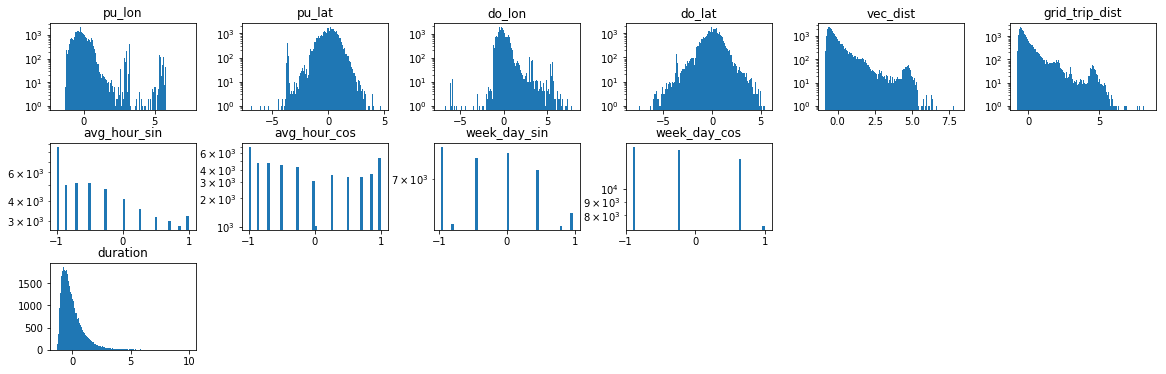

In [181]:
plt.figure(figsize=(16,5))
titles = list(features.columns.values)

for i in range(6):
    plt.subplot(3,6,i+1)
    plt.hist(X[:,i], bins='auto', log=True)
    plt.title(titles[i])

temp_bins = [50,50,50,50]
for i in range(4):
    plt.subplot(3,6,i+7)
    plt.hist(X[:,i+6], bins=temp_bins[i], log=True)
    plt.title(titles[i+6])

plt.subplot(3,6,13)
plt.hist(y, bins='auto')
plt.title('duration')
plt.tight_layout(False)
plt.show()

### 3. Splitting data

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

test_size = len(y_test)
train_size = len(y_train)

y_test_denorm = out_scaler.inverse_transform(y_test)

In [184]:
# # Store splitted data
pkl.dump(X_train, open('../splitted_data/fs4/x_train.dat', 'wb'))
pkl.dump(y_train, open('../splitted_data/fs4/y_train.dat', 'wb'))
pkl.dump(X_test, open('../splitted_data/fs4/x_test.dat', 'wb'))
pkl.dump(y_test, open('../splitted_data/fs4/y_test.dat', 'wb'))

In [11]:
# Read splitted data
X_train = pkl.load(open('../splitted_data/fs4/x_train.dat', 'rb'))
y_train = pkl.load(open('../splitted_data/fs4/y_train.dat', 'rb'))
X_test = pkl.load(open('../splitted_data/fs4/x_test.dat', 'rb'))
y_test = pkl.load(open('../splitted_data/fs4/y_test.dat', 'rb'))

test_size = len(y_test)
train_size = len(y_train)

y_test_denorm = out_scaler.inverse_transform(y_test)

### 4. SVM

In [185]:
kernels = ['rbf']
C_values = [0.1, 1, 10]

#### 4.1 Training

In [186]:
for kern in kernels:
    for C in C_values:
        sys.stdout.write("\rTraining SVM with kernel {0} and C = {1}".format(kern,C))
        svm_reg = svm.SVR(kernel=kern, gamma='auto', C=C)
        svm_reg.fit(X_train, y_train.ravel())
        pkl.dump(svm_reg, open('../init_models/fs4/svms/svm_reg_{0}_{1}.mdl'.format(kern,C), 'wb'))
        sys.stdout.flush()
        clear_output()
sys.stdout.write("Done.")        

Done.

#### 4.2 Testing

In [187]:
y_pred_svm = []
for kern in kernels:
    for C in C_values:
        print("Running tests on SVM with kernel {0} and C = {1}".format(kern,C))
        svm_reg = pkl.load(open('../init_models/fs4/svms/svm_reg_{0}_{1}.mdl'.format(kern,C), 'rb'))
        y_pred_svm.append(svm_reg.predict(X_test))
        sys.stdout.flush()
        clear_output()
sys.stdout.write("Done.")        

Done.

#### Denormalize predicited data

In [188]:
y_pred_svm_denorm = out_scaler.inverse_transform(y_pred_svm)

# Set all negative outputs to zero (we're predicting time)
y_pred_svm_denorm[y_pred_svm_denorm < 0] = 0

# Transform back again
y_pred_svm = out_scaler.transform(y_pred_svm_denorm)

#### 4.3 Metrics

In [194]:
idx = pd.MultiIndex.from_tuples([(k,C) for k in kernels for C in C_values], names=['Kernel','C'])

metrics_svm = compute_metrics(y_true = y_test, y_pred = y_pred_svm, 
                              y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_svm_denorm, 
                              indices = idx)  
metrics_svm

Exp. Var.        R2           MSE        RMSE      nMSE  \
Kernel C                                                               
rbf    0.1    0.756256  0.752474  83469.900064  288.911578  0.242382   
       1.0    0.782370  0.779760  74268.356429  272.522213  0.215662   
       10.0   0.790524  0.788424  71346.891526  267.108389  0.207179   

                nRMSE      MSLE     RMSLE       MAPE  
Kernel C                                              
rbf    0.1   0.492323  0.128634  0.358655  29.314737  
       1.0   0.464395  0.117192  0.342333  27.233850  
       10.0  0.455169  0.114594  0.338518  26.488583

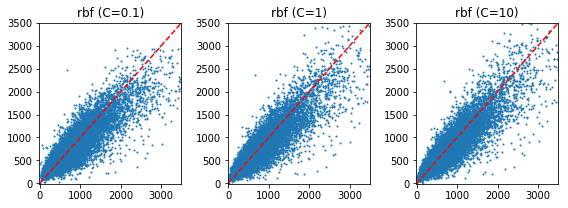

In [190]:
fig = plt.figure(figsize=(8,8))
for i,kern in enumerate(kernels):
    for j,C in enumerate(C_values):
        plt.subplot(3, 3, j + 3*i + 1)
        plt.scatter(y_test_denorm, y_pred_svm_denorm[j + 3*i], s = 1)
        plt.plot((-1,3500),(-1,3500), '--', c='r')
        plt.title('{0} (C={1})'.format(kern,C))
        plt.xlim((-10,3500))
        plt.ylim((-10,3500))
plt.tight_layout()
plt.show()

#### 4.4 Evaluate accuracy agains range of tolerance for best SVM

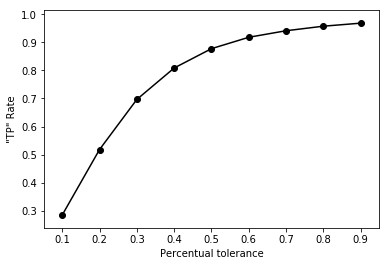

In [191]:
y_pred_svm_best = y_pred_svm_denorm[2].reshape(-1,1)

tolerance = np.arange(0.1,1,0.1)
acc = [np.sum(np.isclose(y_pred_svm_best, y_test_denorm, rtol=tol))/test_size for tol in tolerance]

plt.plot(tolerance, acc, c='k')
plt.scatter(tolerance, acc, c='k')
plt.ylabel('"TP" Rate')
plt.xlabel('Percentual tolerance')
plt.show()

### 5. Random Forests

In [192]:
forest_size = [100,200, 300]
max_feats   = [2,3,4]

#### 5.1 Training

In [193]:
for n_trees in forest_size:
    for max_feat in max_feats:
        sys.stdout.write("\rTraining forest with {0} trees using maximum of {1} features".format(n_trees, max_feat))
        rf_reg = RandomForestRegressor(n_estimators=n_trees, max_features=max_feat, n_jobs=2)
        rf_reg.fit(X_train, y_train.ravel())
        pkl.dump(rf_reg, open('../init_models/fs4/random_forests/rf_reg_{0}_{1}.mdl'.format(n_trees,max_feat), 'wb'))
        sys.stdout.flush()
clear_output()
sys.stdout.write("Done.")        

Done.

#### 5.2 Testing

In [195]:
y_pred_rf = []
for n_trees in forest_size:
    for max_feat in max_feats:
        sys.stdout.write("\rTesting forest with {0} trees using maximum of {1} features".format(n_trees, max_feat))
        rf_reg = pkl.load(open('../init_models/fs4/random_forests/rf_reg_{0}_{1}.mdl'.format(n_trees,max_feat), 'rb'))
        y_pred_rf.append(rf_reg.predict(X_test));
        sys.stdout.flush()
clear_output()
sys.stdout.write("Done.")        

Done.

#### Denormalize predicited data

In [196]:
y_pred_rf_denorm = out_scaler.inverse_transform(y_pred_rf)

# Set all negative outputs to zero (we're predicting time)
y_pred_rf_denorm[y_pred_rf_denorm < 0] = 0

# Transform back again
y_pred_rf = out_scaler.transform(y_pred_rf_denorm)

#### 4.3 Metrics

In [233]:
y_pred_rf_denorm.shape

(9, 14582)

In [197]:
idx = pd.MultiIndex.from_tuples([(f,m) for f in forest_size for m in max_feats], names=['#Tress','MaxFeat'])

metrics_svm = compute_metrics(y_true = y_test, y_pred = y_pred_rf, 
                              y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_rf_denorm, 
                              indices = idx)  
metrics_svm

Exp. Var.        R2           MSE        RMSE      nMSE  \
#Tress MaxFeat                                                            
100    2         0.780237  0.779896  74222.734486  272.438497  0.215530   
       3         0.780808  0.780388  74056.618768  272.133458  0.215047   
       4         0.779609  0.779110  74487.646557  272.924251  0.216299   
200    2         0.780899  0.780548  74002.794022  272.034546  0.214891   
       3         0.782127  0.781686  73619.109539  271.328416  0.213777   
       4         0.782496  0.782006  73511.155171  271.129407  0.213464   
300    2         0.781669  0.781347  73733.290491  271.538746  0.214109   
       3         0.782734  0.782282  73417.969710  270.957505  0.213193   
       4         0.783317  0.782824  73235.112895  270.619868  0.212662   

                   nRMSE      MSLE     RMSLE       MAPE  
#Tress MaxFeat                                           
100    2        0.464252  0.132570  0.364102  32.321352  
       3        0.463732  0.131820  0.363070  31.957341  
       4        0.465080  0.132106  0.363464  31.964412  
200    2        0.463564  0.131978  0.363288  32.051063  
       3        0.462360  0.131125  0.362112  31.940239  
       4        0.462021  0.131595  0.362760  31.944073  
300    2        0.462719  0.131180  0.362188  31.989337  
       3        0.461728  0.130784  0.361641  31.821798  
       4        0.461153  0.131062  0.362024  31.901075

### 6. XGBoost

In [198]:
xgb_reg = xgb.XGBRegressor(n_estimators=300, max_depth=10)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [199]:
y_pred_xgb = xgb_reg.predict(X_test).reshape(1,-1)

In [200]:
y_pred_xgb_denorm = out_scaler.inverse_transform(y_pred_xgb)

# Set all negative outputs to zero (we're predicting time)
y_pred_xgb_denorm[y_pred_xgb_denorm < 0] = 0

# Transform back again
y_pred_xgb = out_scaler.transform(y_pred_xgb_denorm)

In [201]:
compute_metrics(y_true = y_test, y_pred = y_pred_xgb,
                y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_xgb_denorm,
                indices=[0])

,Exp. Var.,R2,MSE,RMSE,nMSE,nRMSE,MSLE,RMSLE,MAPE
0,0.793776,0.793655,69583.005357,263.785908,0.202057,0.449507,0.122912,0.350588,29.502419


### 7. Neural Network

In [227]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(80,40,20,10,1))

In [228]:
mlp_reg.fit(X_train, y_train.ravel())

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(80, 40, 20, 10, 1), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [229]:
y_pred_mlp = mlp_reg.predict(X_test).reshape(1,-1)

In [230]:
y_pred_mlp_denorm = out_scaler.inverse_transform(y_pred_mlp)

# Set all negative outputs to zero (we're predicting time)
y_pred_mlp_denorm[y_pred_mlp_denorm < 0] = 0

# Transform back again
y_pred_mlp = out_scaler.transform(y_pred_mlp_denorm)

In [231]:
compute_metrics(y_true = y_test, y_pred = y_pred_mlp,
                y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_mlp_denorm,
                indices=[0])

,Exp. Var.,R2,MSE,RMSE,nMSE,nRMSE,MSLE,RMSLE,MAPE
0,0.788451,0.788417,71349.189811,267.112691,0.207186,0.455176,0.122665,0.350236,29.921575


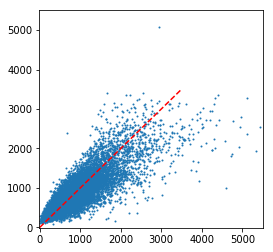

In [33]:
fig = plt.figure(figsize=(4,4))
plt.scatter(y_test_denorm, y_pred_mlp_denorm, s = 1)
plt.plot((-1,3500),(-1,3500), '--', c='r')
plt.xlim((-10,5500))
plt.ylim((-10,5500))
plt.show()